# Summary

The dataset for this project contains 4210 manually annotated images of Egyptian hieroglyphs found in the [Pyramid of Unas](https://en.wikipedia.org/wiki/Pyramid_of_Unas) and is also available to download from [here](http://iamai.nl/downloads/GlyphDataset.zip).

[Gardiner's Sign List](https://en.wikipedia.org/wiki/Gardiner%27s_sign_list) is considered a standard reference in the study of ancient Egyptian hieroglyphs.
The goal is to train an image classifier to recognize different hieroglyphs and predict their Gardiner labels:

**S29** | **M17** | **X1** | **G43**
- | - | - |-
![s29](./data/test/S29/200086_S29.png) | ![m17](./data/test/M17/390082_M17.png) | ![x1](./data/test/X1/070100_X1.png) | ![g43](./data/test/G43/030245_G43.png) 


In this project we will only use a fraction of the dataset to train:
1. Convolutional Neural Network from scratch 
2. The last few layers of **VGG16** Neural Network with a few additional layers (transfer learning)

# Load and Explore the Dataset

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import os
import warnings
from datetime import datetime
import keras
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.applications import *
import tensorflow_hub as hub
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D

warnings.filterwarnings('ignore')

In [2]:
base_dir = './data'
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

train_G43_dir = os.path.join(train_dir, 'G43')  
train_S29_dir = os.path.join(train_dir, 'S29')  
train_M17_dir = os.path.join(train_dir, 'M17')  
train_X1_dir = os.path.join(train_dir, 'X1')

validation_G43_dir = os.path.join(validation_dir, 'G43')
validation_S29_dir = os.path.join(validation_dir, 'S29') 
validation_M17_dir = os.path.join(validation_dir, 'M17') 
validation_X1_dir = os.path.join(validation_dir, 'X1') 

test_G43_dir = os.path.join(test_dir, 'G43')
test_S29_dir = os.path.join(test_dir, 'S29') 
test_M17_dir = os.path.join(test_dir, 'M17') 
test_X1_dir = os.path.join(test_dir, 'X1')

num_G43_tr = len(os.listdir(train_G43_dir))
num_S29_tr = len(os.listdir(train_S29_dir))
num_M17_tr = len(os.listdir(train_M17_dir))
num_X1_tr = len(os.listdir(train_X1_dir))

num_G43_val = len(os.listdir(validation_G43_dir))
num_S29_val = len(os.listdir(validation_S29_dir))
num_M17_val = len(os.listdir(validation_M17_dir))
num_X1_val = len(os.listdir(validation_X1_dir))

total_train = num_G43_tr + num_S29_tr + num_M17_tr + num_X1_tr
total_val = num_G43_val + num_S29_val + num_M17_val + num_X1_val

print('The dataset contains:')
print('\u2022 {:,} training images'.format(total_train))
print('\u2022 {:,} validation images'.format(total_val))

print('\nThe training set contains:')
print('\u2022 {:,} G43 images'.format(num_G43_tr))
print('\u2022 {:,} S29 images'.format(num_S29_tr))
print('\u2022 {:,} M17 images'.format(num_M17_tr))
print('\u2022 {:,} X1 images'.format(num_X1_tr))

print('\nThe validation set contains:')
print('\u2022 {:,} G43 images'.format(num_G43_val))
print('\u2022 {:,} S29 images'.format(num_S29_val))
print('\u2022 {:,} M17 images'.format(num_M17_val))
print('\u2022 {:,} X1 images'.format(num_X1_val))

The dataset contains:
• 1,060 training images
• 200 validation images

The training set contains:
• 300 G43 images
• 300 S29 images
• 300 M17 images
• 160 X1 images

The validation set contains:
• 50 G43 images
• 50 S29 images
• 50 M17 images
• 50 X1 images


**Rescale** is a value by which we will multiply the data before any other processing. Our original images consist in RGB coefficients in the 0-255, but such values would be too high for our models to process, so we target values between 0 and 1 instead by scaling with a 1/255. factor.

In [3]:
BATCH_SIZE = 64
IMG_HEIGHT  = 75
IMG_WIDTH = 50
image_gen = ImageDataGenerator(rescale=1./255)

one_image = image_gen.flow_from_directory(directory=train_dir,
                                          batch_size=1,
                                          shuffle=True,
                                          target_size=(IMG_HEIGHT,IMG_WIDTH),
                                          class_mode='binary')

#plt.imshow(one_image[0][0][0])
#plt.show()
one_image[0][0][0].shape

Found 1060 images belonging to 4 classes.


(75, 50, 3)

In [4]:
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 5, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

## Generate training dataset
Randomly **flipping** the images horizontally, this is relevant because in this case there are no assumptions of horizontal assymetry.

Found 1060 images belonging to 4 classes.


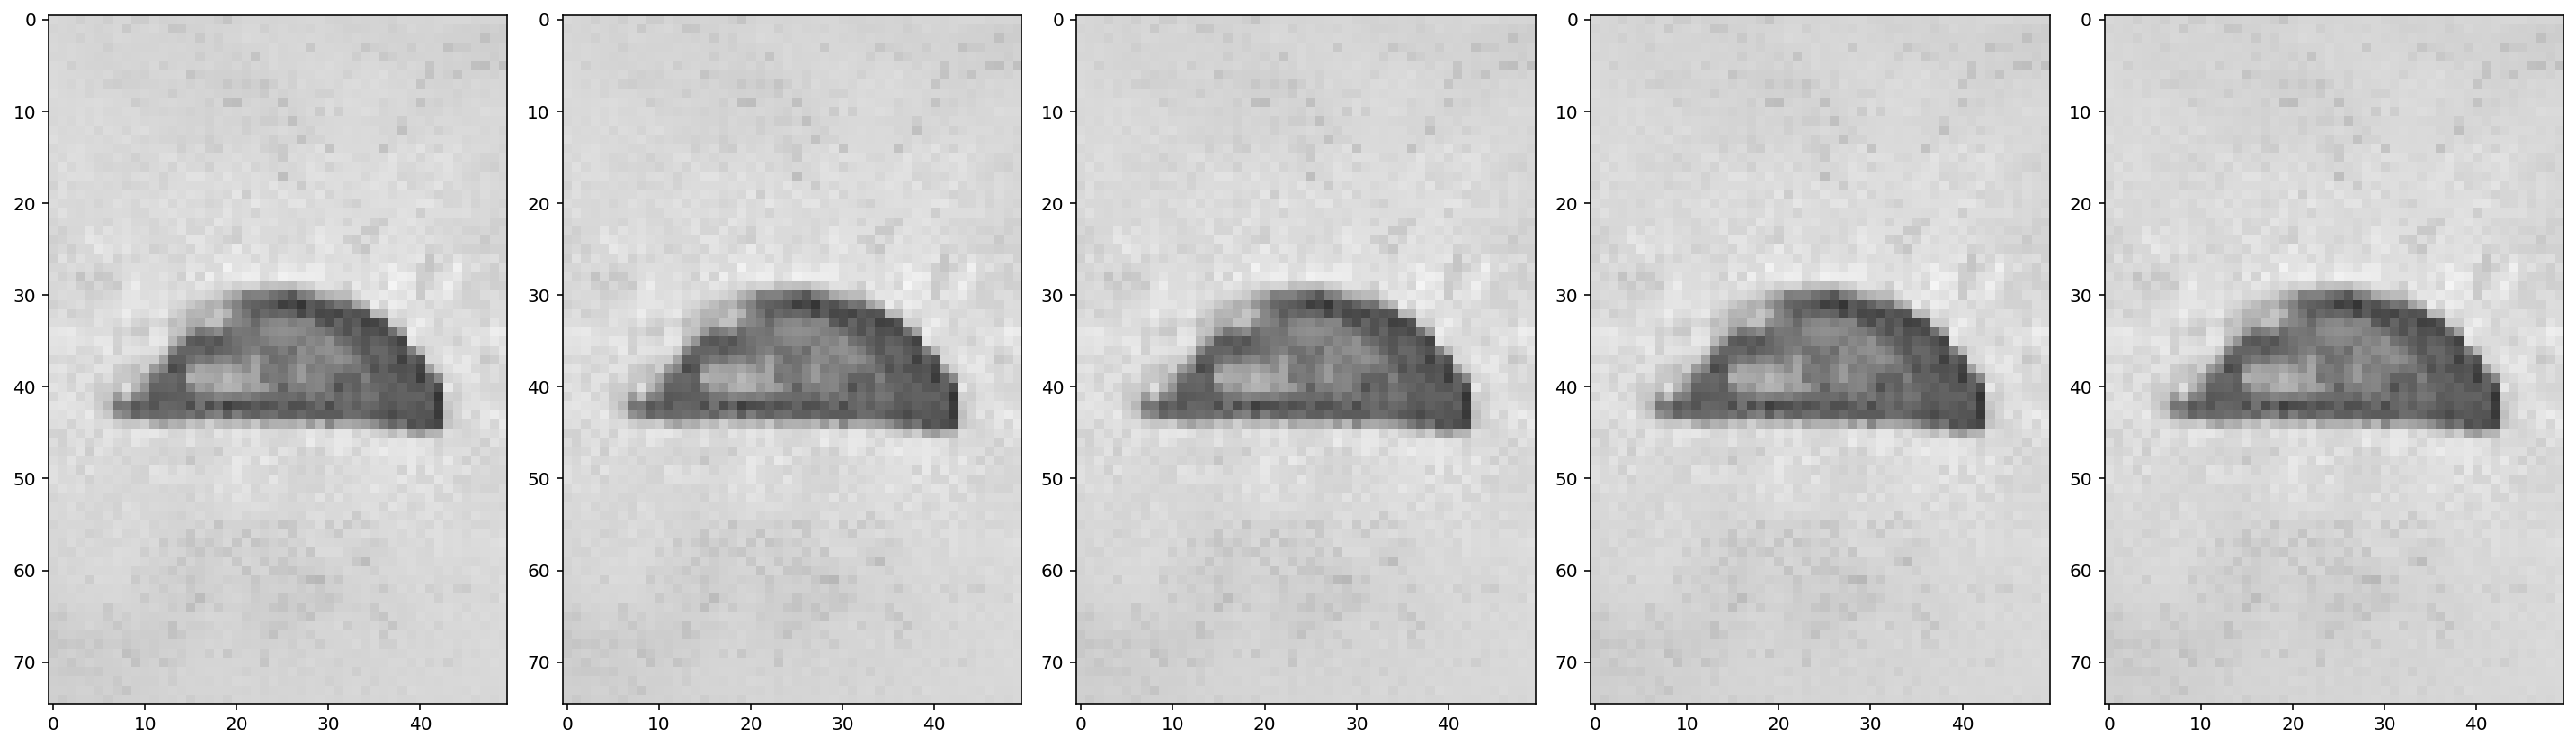

In [5]:
image_gen = ImageDataGenerator(rescale=1./255, horizontal_flip=True)

train_data_gen = image_gen.flow_from_directory(directory=train_dir,
                                               batch_size=BATCH_SIZE,
                                               shuffle=True, 
                                               target_size=(IMG_HEIGHT,IMG_WIDTH),
                                               class_mode='binary')
augmented_images = [train_data_gen[0][0][0] for i in range(5)]
plotImages(augmented_images)

## Generate validation dataset and test batch

In [6]:
image_gen_val = ImageDataGenerator(rescale=1./255)

val_data_gen = image_gen_val.flow_from_directory(directory=validation_dir,
                                                 batch_size=23,
                                                 target_size=(IMG_HEIGHT,IMG_WIDTH),
                                                 class_mode='binary')

Found 200 images belonging to 4 classes.


Found 4 images belonging to 4 classes.


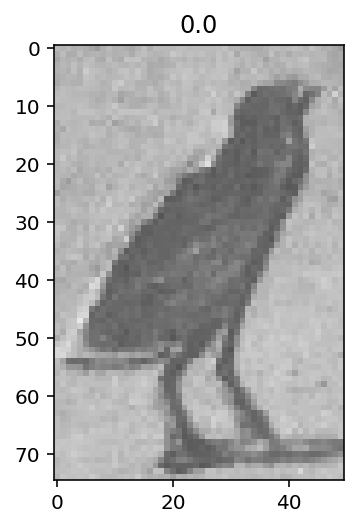

In [7]:
image_gen = ImageDataGenerator(rescale=1./255)
# create a test batch of 4 images
test_batch = image_gen.flow_from_directory(directory=test_dir,
                                          batch_size=4,
                                          shuffle=True,
                                          target_size=(75,50),
                                          class_mode='binary')

t, l = next(test_batch)
plt.imshow(t[1])
plt.title(l[1])
plt.show()

# Build and Train the Classifier

## Model 1 
- Define a new, untrained network with 9 layers:
    - 3 convolutional layers
    - 2 max pooling layers
    - 1 flatten layer
    - 2 dense layers
- Train the model
- Plot the loss and accuracy values achieved during training for the training and validation set
- Save the trained models as a Keras model

In [8]:
model1 = Sequential([
    Conv2D(16, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    MaxPooling2D(),
    Conv2D(32, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Conv2D(64, 3, padding='same', activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(4, 'softmax')
])

In [9]:
model1.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])
EPOCHS_1 = 4
t1 = datetime.now()
history_1 = model1.fit(train_data_gen,
                              epochs=EPOCHS_1,
                              steps_per_epoch=len(train_data_gen),
                              validation_data=val_data_gen)
train_time_1 = datetime.now() - t1

Epoch 1/4
17/17 [==============================] - 2s 116ms/step - loss: 1.3074 - sparse_categorical_accuracy: 0.3783 - val_loss: 1.1520 - val_sparse_categorical_accuracy: 0.6300
Epoch 2/4
17/17 [==============================] - 2s 104ms/step - loss: 0.6615 - sparse_categorical_accuracy: 0.8142 - val_loss: 0.2800 - val_sparse_categorical_accuracy: 0.9000
Epoch 3/4
17/17 [==============================] - 2s 111ms/step - loss: 0.2303 - sparse_categorical_accuracy: 0.9132 - val_loss: 0.2567 - val_sparse_categorical_accuracy: 0.8900
Epoch 4/4
17/17 [==============================] - 2s 128ms/step - loss: 0.1475 - sparse_categorical_accuracy: 0.9519 - val_loss: 0.4528 - val_sparse_categorical_accuracy: 0.8300


In [10]:
loss_1, test_accuracy_1 = model1.evaluate(test_batch)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss_1))
print('Accuracy on the TEST Set: {:.3%}'.format(test_accuracy_1))

1/1 [==============================] - 0s 996us/step - loss: 0.0313 - sparse_categorical_accuracy: 1.0000

Loss on the TEST Set: 0.031
Accuracy on the TEST Set: 100.000%


In [11]:
model1.save('model1.h5')

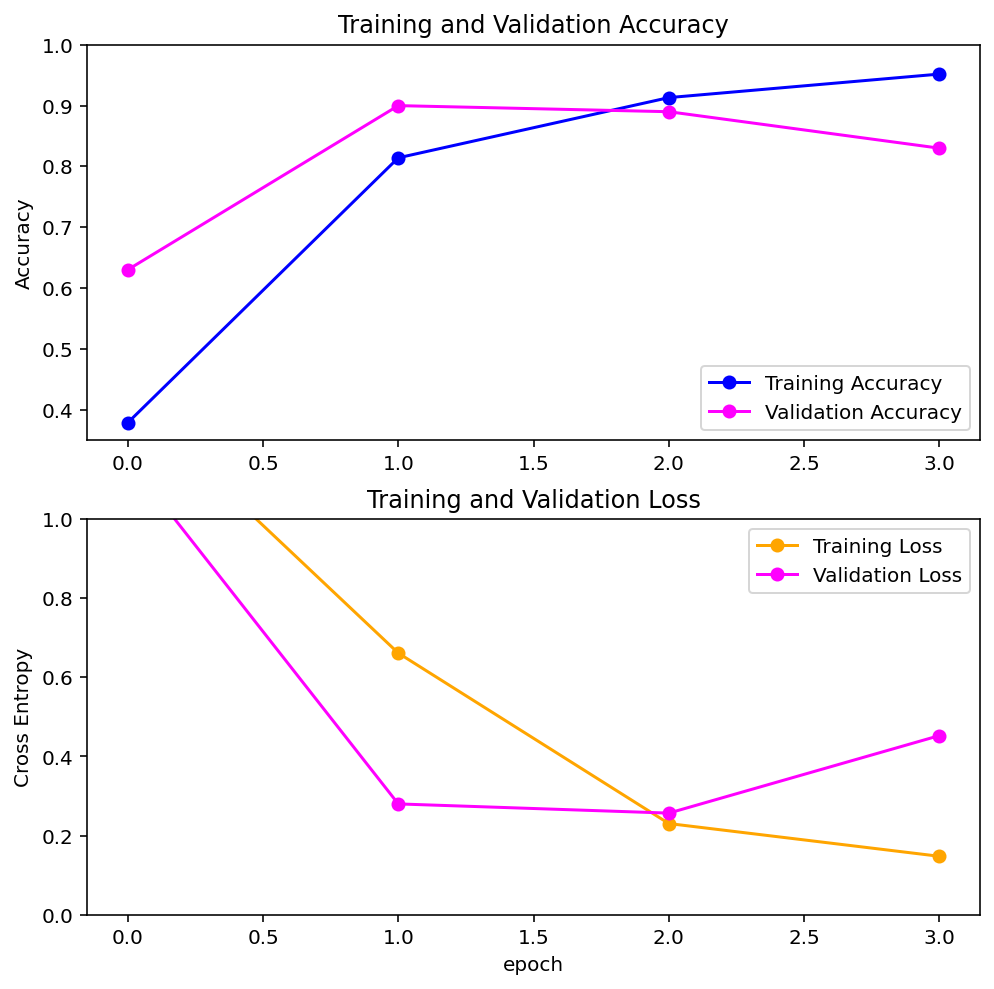

In [12]:
acc = history_1.history['sparse_categorical_accuracy']
val_acc = history_1.history['val_sparse_categorical_accuracy']

loss = history_1.history['loss']
val_loss = history_1.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', marker='o', color="blue")
plt.plot(val_acc, label='Validation Accuracy', marker='o', color="magenta",)
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', marker='o', color="orange")
plt.plot(val_loss, label='Validation Loss', marker='o', color="magenta",)
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Model 2 
- Load the **VGG16** pre-trained network from keras
- Define a new, untrained network and add it to VGG16 as a top layer model
- Freeze the majority of VGG16 and only train/fine-tune the top layers
- Plot the loss and accuracy values achieved during training for the training and validation set
- Save the trained models as a Keras model

In [13]:
model2 = VGG16(weights='imagenet', include_top=False, input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))
model2.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 75, 50, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 75, 50, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 75, 50, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 37, 25, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 37, 25, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 37, 25, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 18, 12, 128)       0     

In [14]:
top_model2 = Sequential()
top_model2.add(Flatten(input_shape=(model2.output_shape[1:])))
top_model2.add(Dense(1024, activation='relu'))
top_model2.add(Dense(512, activation='relu'))
top_model2.add(Dense(4, activation='softmax'))

model2 = Model(inputs=model2.input, outputs=top_model2(model2.output))

# only train the additional layers and the last layer of VGG16, freeze the rest
for layer in model2.layers[:-(len(top_model2.layers)+1)]:
    layer.trainable = False

In [15]:
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['sparse_categorical_accuracy'])

EPOCHS_2 = 4
t2 = datetime.now()
history_2 = model2.fit(train_data_gen,
                              epochs=EPOCHS_2,
                              steps_per_epoch=len(train_data_gen),
                              validation_data=val_data_gen)
train_time_2 = datetime.now() - t2

Epoch 1/4
17/17 [==============================] - 19s 1s/step - loss: 0.8854 - sparse_categorical_accuracy: 0.5670 - val_loss: 0.1920 - val_sparse_categorical_accuracy: 0.9200
Epoch 2/4
17/17 [==============================] - 22s 1s/step - loss: 0.0726 - sparse_categorical_accuracy: 0.9792 - val_loss: 0.1162 - val_sparse_categorical_accuracy: 0.9650
Epoch 3/4
17/17 [==============================] - 25s 1s/step - loss: 0.0477 - sparse_categorical_accuracy: 0.9877 - val_loss: 0.0697 - val_sparse_categorical_accuracy: 0.9900
Epoch 4/4
17/17 [==============================] - 26s 2s/step - loss: 0.0571 - sparse_categorical_accuracy: 0.9811 - val_loss: 0.1174 - val_sparse_categorical_accuracy: 0.9650


In [16]:
loss_2, test_accuracy_2 = model2.evaluate(test_batch)

print('\nLoss on the TEST Set: {:,.3f}'.format(loss_2))
print('Accuracy on the TEST Set: {:.3%}'.format(test_accuracy_2))

1/1 [==============================] - 0s 3ms/step - loss: 0.0012 - sparse_categorical_accuracy: 1.0000

Loss on the TEST Set: 0.001
Accuracy on the TEST Set: 100.000%


In [17]:
model2.save('model2.h5')

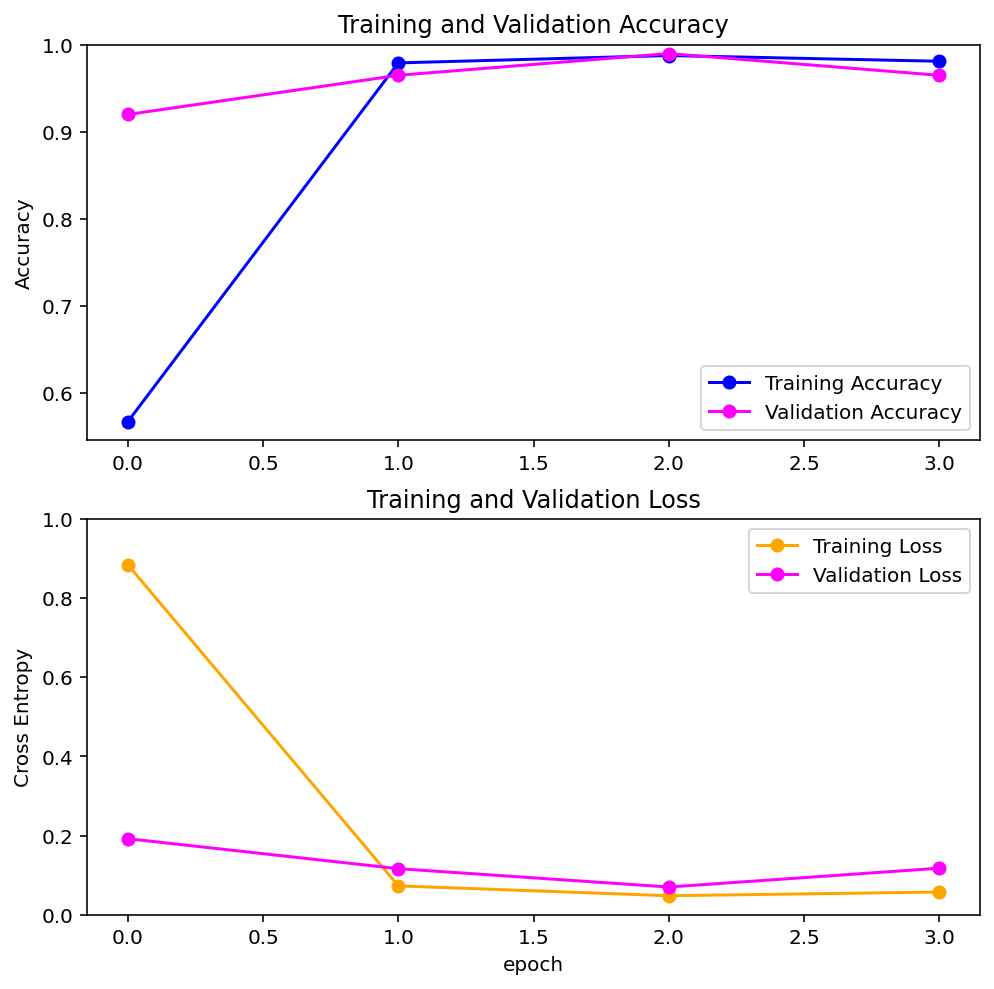

In [18]:
acc = history_2.history['sparse_categorical_accuracy']
val_acc = history_2.history['val_sparse_categorical_accuracy']

loss = history_2.history['loss']
val_loss = history_2.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy', marker='o', color="blue")
plt.plot(val_acc, label='Validation Accuracy', marker='o', color="magenta")
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss', marker='o', color="orange")
plt.plot(val_loss, label='Validation Loss', marker='o', color="magenta")
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

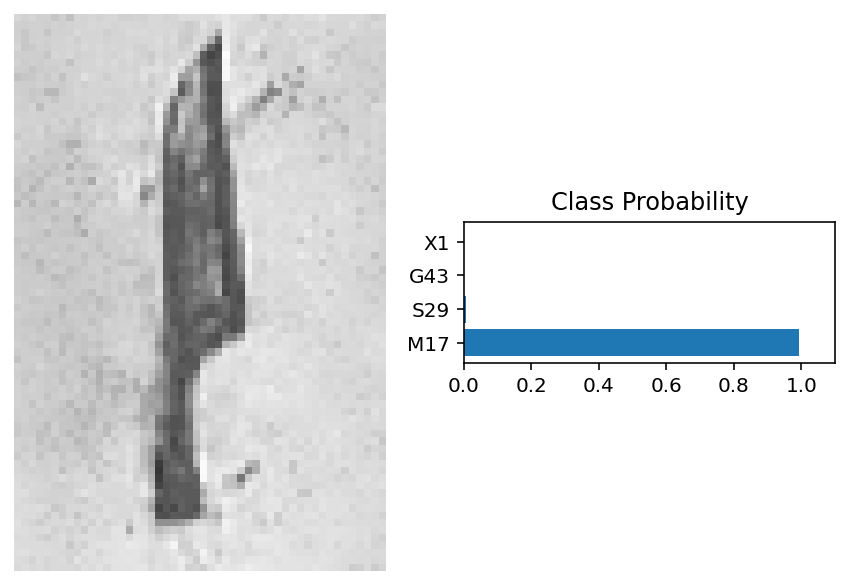

In [19]:
# Load model 1
reloaded_model1 = tf.keras.models.load_model('model1.h5', custom_objects={'KerasLayer': hub.KerasLayer})

test_img = test_batch[0][0][1]
preds = reloaded_model1.predict(x = np.expand_dims(test_img, axis=0))
# Returns the top K most likely class labels along with the probabilities
probs, class_idx = tf.math.top_k(preds, k=4)
class_names = ['G43', 'M17', 'S29', 'X1']
classes=[]
for i in class_idx.numpy()[0]:
    classes.append(class_names[i])

fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(test_img, cmap = plt.cm.binary)
ax1.axis('off')
ax2.barh(np.arange(4), list(probs.numpy()[0]))
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(4))
ax2.set_yticklabels(classes);
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()

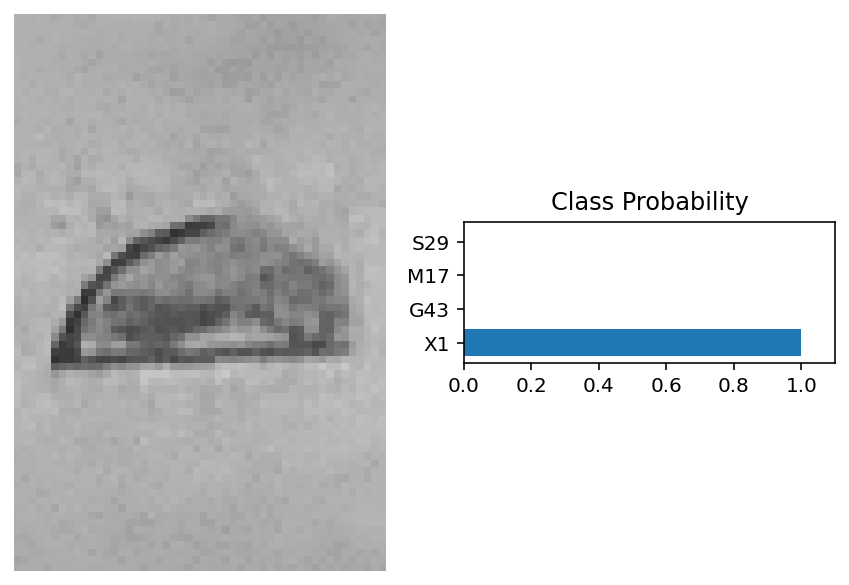

In [20]:
# Load model 2
reloaded_model2 = tf.keras.models.load_model('model2.h5', custom_objects={'KerasLayer': hub.KerasLayer})

test_img = test_batch[0][0][2]
preds = reloaded_model2.predict(x = np.expand_dims(test_img, axis=0))
probs, class_idx = tf.math.top_k(preds, k=4)
class_names = ['G43', 'M17', 'S29', 'X1']
classes=[]
for i in class_idx.numpy()[0]:
    classes.append(class_names[i])

fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
ax1.imshow(test_img, cmap = plt.cm.binary)
ax1.axis('off')
ax2.barh(np.arange(4), list(probs.numpy()[0]))
ax2.set_aspect(0.1)
ax2.set_yticks(np.arange(4))
ax2.set_yticklabels(classes);
ax2.set_title('Class Probability')
ax2.set_xlim(0, 1.1)
plt.tight_layout()

In [21]:
pd.DataFrame([[train_time_1.seconds, EPOCHS_1, 
               history_1.history['sparse_categorical_accuracy'][-1], test_accuracy_1],
              [train_time_2.seconds,EPOCHS_2, 
               history_2.history['sparse_categorical_accuracy'][-1], test_accuracy_2]],
             columns=['Train time in seconds', 'Number of Epochs', 'Sparse categorical Accuracy in last epoch',
                      'Test accuracy'], index=['CNN from scratch', 'VGG16 transfer-learning'])

,Train time in seconds,Number of Epochs,Sparse categorical Accuracy in last epoch,Test accuracy
CNN from scratch,9,4,0.951887,1.0
VGG16 transfer-learning,97,4,0.981132,1.0


# Results

The classsification report of both classifier above shows that we can predict hieroglyphs with 100% test accuracy. The train time for VGG16 with transfer learning is significantly higher than training our CNN from scratch. However we see that using a pre-trained network with transfer learning did not make a huge difference in terms of accuracy although ~100% accuracy suggests overfitting and therefore testing the model on a larger test batch could reveal a more realistic accuracy.

# Next Steps

We could further experiment trying out other pre-trained models with different architecture such as Xception, ResNet or Inception. 